In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 💡 Reasoning for choosing a model and why it was a bad chose

📝 Initially, I considered LSTM as the main model because I thought it was important to preserve the context of previous games, and I also believed it would be beneficial for the bot to think strategically (for example, saving a slot for an “I”). However, since the data was generated by a heuristic bot rather than actual players, it was quite repetitive, and the model did not deliver the results I was hoping for. Nevertheless, I decided to keep this model as an experiment.
### LSTM (Long Short-Term Memory)
- A recurrent neural network that can "remember" previous states.  
- Input: a sequence of several consecutive game states.  
- Output: the action for the last state in the sequence.  


## 🧮 Mathematical view of CNN for Tetris

### A. Feature Construction

Each Tetris board state is converted into a numerical feature vector:

**a) Heights normalization**
The heights of each of the 10 columns are scaled to the range \([0,1]\):
$
h_i^{norm} = \frac{h_i}{20}
$

**b) One-hot encoding for piece type**
A piece type (I, O, T, L, J, S, Z) is converted into a binary vector:
$
\text{e.g., T-piece} \rightarrow [0,0,1,0,0,0,0]
$

**c) Numeric features (e.g., holes, bumpiness, cleared lines)**
These are standardized using:
$
x^{scaled} = \frac{x - \mu}{\sigma}
$

 Final feature vector:
$
\mathbf{f}_t = [\text{normalized heights},\ \text{scaled numeric features},\ \text{one-hot piece type}]
$
This vector represents the game state at time step \(t\).

---

### B. Sequence Creation (Time Series Input)

Instead of using a single game state, we use a sequence of states:
$
X_t = \{ \mathbf{f}_{t-14}, \dots, \mathbf{f}_t \}
$
The target label is the action taken at the next time step:
$
y_t = a_{t+1}
$
This models the probability:
$
P(a_{t+1} \mid \mathbf{f}_{t-14}, \dots, \mathbf{f}_t)
$

---

### C. LSTM Mathematics

For each time step \(t\), the LSTM updates its internal hidden state \(\mathbf{h}_t\) and cell state \(\mathbf{c}_t\):

$
\begin{aligned}
\mathbf{i}_t &= \sigma(W_i \mathbf{f}_t + U_i \mathbf{h}_{t-1} + b_i) &\text{(input gate)}\\
\mathbf{f}_t &= \sigma(W_f \mathbf{f}_t + U_f \mathbf{h}_{t-1} + b_f) &\text{(forget gate)}\\
\mathbf{g}_t &= \tanh(W_g \mathbf{f}_t + U_g \mathbf{h}_{t-1} + b_g) &\text{(candidate state)}\\
\mathbf{c}_t &= \mathbf{f}_t \odot \mathbf{c}_{t-1} + \mathbf{i}_t \odot \mathbf{g}_t &\text{(cell state)}\\
\mathbf{o}_t &= \sigma(W_o \mathbf{f}_t + U_o \mathbf{h}_{t-1} + b_o) &\text{(output gate)}\\
\mathbf{h}_t &= \mathbf{o}_t \odot \tanh(\mathbf{c}_t) &\text{(hidden state)}
\end{aligned}
$

The final hidden state \(\mathbf{h}_T\) (from the last time step in the sequence) is passed to a fully-connected layer:
$
\mathbf{z} = W_{fc} \mathbf{h}_T + b
$
where \(\mathbf{z} \in \mathbb{R}^{40}\) represents logits for 40 possible actions (4 rotations × 10 columns).

---

### D. Action Prediction (Softmax)

The probability distribution over actions is obtained using the softmax function:
$
P(a = k \mid X) = \frac{e^{z_k}}{\sum_{j=1}^{40} e^{z_j}}
$

---

### E. Loss Function: Cross Entropy

For a true action label \(y\), the loss is:
$
\mathcal{L} = -\log \left( \frac{e^{z_y}}{\sum_j e^{z_j}} \right)
$

Gradient-based optimization (AdamW):
$
w_{\text{new}} = w - \eta \Big( \frac{\partial \mathcal{L}}{\partial w} + \lambda w \Big)
$
where:
- \(\eta\) is the learning rate,
- \(\lambda\) is weight decay (L2 regularization).

---

### D. Goal of the Model

The model learns a **policy function**:
$
\pi_\theta(a \mid s_{t-14:t}) \approx P(a \mid \text{past 15 game states})
$
This is a form of **behavior cloning**:
- We are not discovering optimal actions.
- We are imitating the actions of an expert player based on previous states.


This LSTM model is learning *how a human (or expert AI) plays Tetris over time*. It takes sequences of board states and predicts the next move using temporal patterns. Mathematically, it approximates a conditional probability distribution over actions using sequence modeling and gradient-based optimization.

---


## 📊 Data Preparation and analysis


📝 A script was written to record the moves of a heuristic bot in order to create the dataset. Before starting the training based on the heuristic bot’s moves, I would first like to analyze its actions in order to understand its average level of play and take its weaknesses into account.

In [9]:
path = "/Users/cory/Tetris_AI/datasets/tetris_dataset_v2.csv"
df = pd.read_csv(path)
#df = df[df["game_id"] < 10]
df.groupby('game_id')
game_lengths = df.groupby("game_id").size()
print(game_lengths.min())
print(game_lengths.max())
df

159
31799


,game_id,kind,rot,x,heights,holes,bumpiness,cleared,aggregate_height,max_height,holes_density,surface_roughness,score,is_best
0,1,J,0,1,"2,1,1,0,0,0,0,0,0,0",0,2,0,4,2,0.000,2,-2.4,NaN
1,1,O,0,1,"2,3,3,0,0,0,0,0,0,0",0,4,0,8,3,0.000,4,-4.8,NaN
2,1,Z,1,0,"4,5,3,0,0,0,0,0,0,0",0,6,0,12,5,0.000,6,-7.2,NaN
3,1,L,1,3,"4,5,3,3,1,0,0,0,0,0",0,6,0,16,5,0.000,6,-9.2,NaN
4,1,S,1,4,"4,5,3,3,3,2,0,0,0,0",0,6,0,20,5,0.000,6,-11.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799048,100,Z,1,0,"15,16,15,17,16,16,16,15,15,16",15,7,1,157,17,0.075,7,-80.4,NaN
799049,100,O,0,7,"15,16,15,17,16,16,16,17,17,16",15,7,0,161,17,0.075,7,-92.4,NaN
799050,100,T,0,5,"15,16,15,17,17,18,17,17,17,16",15,7,0,165,18,0.075,7,-94.4,NaN
799051,100,S,1,1,"15,18,17,17,17,18,17,17,17,16",15,7,0,169,18,0.075,7,-96.4,NaN


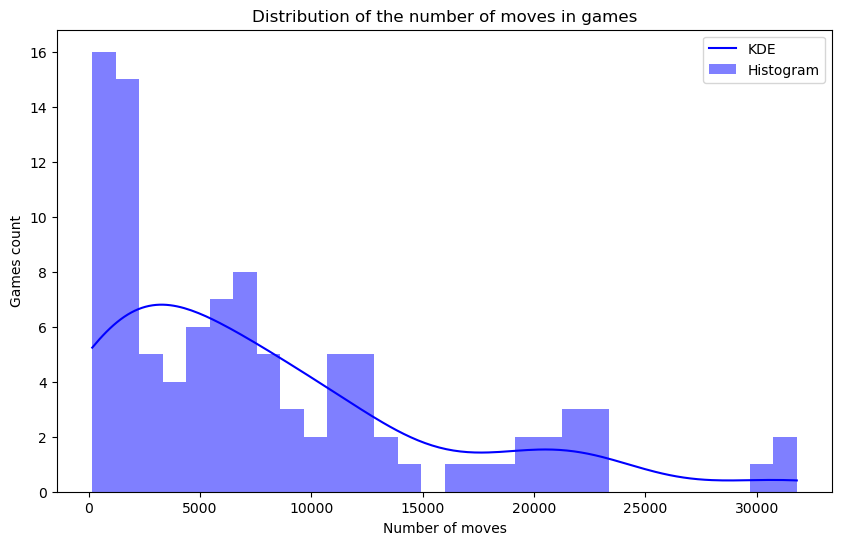

In [11]:
moves_per_game = df.groupby('game_id').size().reset_index(name='num_moves')

plt.figure(figsize=(10,6))
sns.histplot(
    data=moves_per_game, 
    x='num_moves', 
    bins=30, 
    kde=True,               
    color='blue', 
    edgecolor=None, 
    label='Games'
)

plt.legend(["KDE", "Histogram"])
plt.title('Distribution of the number of moves in games')
plt.xlabel('Number of moves')
plt.ylabel('Games count')
plt.show()


📝 Most games end within a relatively small number of moves (up to 100), but there are rare cases of extremely long games (up to 30000! moves). The distribution has a right skew and resembles a log-normal or exponentially decaying distribution. In Tetris, most players play short games; they lose quickly due to mistakes, unfavorable pieces, or inexperience. However, there are a few players who play for a long time and steadily, with games lasting tens of times longer than the average. It follows that in a dataset of real players’ games, the distribution would be approximately the same.

Even though the data reflect possible moves of real players, such a distribution has the following drawbacks:
* Very long sequences — games of up to 30000 moves create memory and gradient issues (mb to either truncate sequences, use batches with clipping, or segment sequences).
* Strong distribution skew — most games are short, while long games are rare. LSTM may struggle to learn from long games because they occur infrequently (mb try weighting or oversampling the long games)
* Uneven learning — the model may “memorize” only short sequences if long games are too rare.

In [15]:
df = pd.get_dummies(df, columns=["kind"], prefix="kind")

NUM_ROTATIONS = 4
NUM_COLS = 10
num_actions = NUM_COLS * NUM_ROTATIONS
df['action'] = df['rot'] + df['x'] * NUM_ROTATIONS

unique_games = df["game_id"].unique()
train_games, temp_games = train_test_split(unique_games, test_size=0.4, random_state=42)
val_games, test_games = train_test_split(temp_games, test_size=0.5, random_state=42)

train_df = df[df["game_id"].isin(train_games)].reset_index(drop=True)
val_df   = df[df["game_id"].isin(val_games)].reset_index(drop=True)
test_df  = df[df["game_id"].isin(test_games)].reset_index(drop=True)

num_cols = ['holes', 'bumpiness', 'cleared', 'aggregate_height', 'max_height', 'holes_density', 'surface_roughness']


### 🚫 Why game sequences must not be mixed between train and test sets
When splitting the dataset into training and testing sets, we must ensure that no single game’s moves are divided between them.
If the same game appears partially in both sets, the model will effectively see part of the test data during training, leading to data leakage.


To prevent data leakage:
* Split the dataset by game_id, not by individual rows.
* Ensure no overlap of games between train and test sets.
* Build sequences (SEQ_LEN steps) only within a single game, never across games.

In [19]:
SEQ_LEN = 15
BATCH_SIZE = 128

scaler = StandardScaler()
scaler.fit(train_df[num_cols].values.astype(np.float32))

np.savez("scaler_params.npz", mean=scaler.mean_, scale=scaler.scale_)
print(f"Scaler parameters saved to scaler_params.npz")
print(f"Mean: {scaler.mean_}")
print(f"Scale: {scaler.scale_}")

train_num_arr = scaler.transform(train_df[num_cols].values.astype(np.float32))
val_num_arr = scaler.transform(val_df[num_cols].values.astype(np.float32))
test_num_arr = scaler.transform(test_df[num_cols].values.astype(np.float32))

def create_features_column(df_split, num_arr_split):
    heights_arr = np.stack(df_split["heights"].apply(lambda x: np.fromstring(x, sep=",")).values).astype(np.float32)
    heights_arr /= 20.0
    
    kind_cols = [c for c in df_split.columns if c.startswith("kind_")]
    kind_arr = df_split[kind_cols].values.astype(np.float32)
    
    features_arr = np.hstack([heights_arr, num_arr_split, kind_arr])
    return list(features_arr)

train_df["features"] = create_features_column(train_df, train_num_arr)
val_df["features"] = create_features_column(val_df, val_num_arr)
test_df["features"] = create_features_column(test_df, test_num_arr)

class ActorDataset(Dataset):
    def __init__(self, df, seq_len, num_actions):
        self.seq_len = seq_len
        self.num_actions = num_actions
        self.sequences = []
        self.targets = []

        for game_id, game_df in df.groupby("game_id"):
            X_game = np.stack(game_df["features"].values)
            y_game = game_df["action"].values
            n_seq = len(X_game) - seq_len
            if n_seq <= 0:
                continue

            for i in range(n_seq):
                X_seq = X_game[i:i+seq_len]
                y_seq = y_game[i+seq_len]
                if 0 <= y_seq < num_actions:
                    self.sequences.append(X_seq)
                    self.targets.append(y_seq)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), \
               torch.tensor(self.targets[idx], dtype=torch.long)

train_dataset = ActorDataset(train_df, SEQ_LEN, num_actions)
val_dataset = ActorDataset(val_df, SEQ_LEN, num_actions)
test_dataset  = ActorDataset(test_df, SEQ_LEN, num_actions)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

if len(train_dataset) > 0:
    input_dim = train_dataset[0][0].shape[1]
    print(f"Input dimension: {input_dim}")
else:
    input_dim = 24 
    print(f"{input_dim}")


Scaler parameters saved to scaler_params.npz
Mean: [2.41998922e+00 7.74577928e+00 3.98180399e-01 3.87528774e+01
 5.66546538e+00 1.20999460e-02 7.74577928e+00]
Scale: [2.61234217e+00 2.89468381e+00 5.78000612e-01 2.51310845e+01
 2.77602653e+00 1.30617108e-02 2.89468381e+00]
Input dimension: 24


In [21]:
print(test_df.columns)
train_dataset[0][0].shape[1]

Index(['game_id', 'rot', 'x', 'heights', 'holes', 'bumpiness', 'cleared',
       'aggregate_height', 'max_height', 'holes_density', 'surface_roughness',
       'score', 'is_best', 'kind_I', 'kind_J', 'kind_L', 'kind_O', 'kind_S',
       'kind_T', 'kind_Z', 'action', 'features'],
      dtype='object')


24

📝 For tracking overfitting and avoiding data leakage, a validation set was also created.

## ⏳ Training

In [25]:
EPOCHS = 80
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class ActorLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, dropout=0, num_actions=40):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, num_actions)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  

model = ActorLSTM(input_dim=input_dim, num_actions=num_actions).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

train_losses, val_losses, val_accuracies = [], [], []
best_val_acc = 0.0  

def accuracy(preds, targets):
    _, predicted = torch.max(preds, dim=1)
    return (predicted == targets).float().mean().item()

print("Starting Actor LSTM training...\n")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    start_time = time.time()

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

    if len(train_loader) > 0:
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
    else:
        avg_train_loss = 0.0

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            val_loss += criterion(logits, y_batch).item()

            _, predicted = torch.max(logits, dim=1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    if len(val_loader) > 0 and total > 0:
        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
    else:
        avg_val_loss = 0.0
        val_acc = 0.0


    scheduler.step(avg_val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "tetris_actor_lstm_best.pth")

    print(f"Epoch {epoch+1}/{EPOCHS} | train_loss: {avg_train_loss:.4f} | "
          f"val_loss: {avg_val_loss:.4f} | val_acc: {val_acc:.4f} | "
          f"time: {time.time()-start_time:.2f}s")


Using device: cpu
Starting Actor LSTM training...

Epoch 1/80 | train_loss: 3.1740 | val_loss: 3.0109 | val_acc: 0.1667 | time: 24.04s
Epoch 2/80 | train_loss: 2.9003 | val_loss: 2.8202 | val_acc: 0.2063 | time: 24.46s
Epoch 3/80 | train_loss: 2.7706 | val_loss: 2.7483 | val_acc: 0.2205 | time: 23.33s
Epoch 4/80 | train_loss: 2.7110 | val_loss: 2.7057 | val_acc: 0.2270 | time: 22.80s
Epoch 5/80 | train_loss: 2.6721 | val_loss: 2.6717 | val_acc: 0.2344 | time: 22.62s
Epoch 6/80 | train_loss: 2.6427 | val_loss: 2.6430 | val_acc: 0.2394 | time: 22.48s
Epoch 7/80 | train_loss: 2.6183 | val_loss: 2.6218 | val_acc: 0.2428 | time: 22.44s
Epoch 8/80 | train_loss: 2.5976 | val_loss: 2.6057 | val_acc: 0.2466 | time: 22.36s
Epoch 9/80 | train_loss: 2.5781 | val_loss: 2.5865 | val_acc: 0.2512 | time: 23.50s
Epoch 10/80 | train_loss: 2.5597 | val_loss: 2.5722 | val_acc: 0.2541 | time: 24.41s
Epoch 11/80 | train_loss: 2.5435 | val_loss: 2.5544 | val_acc: 0.2581 | time: 23.59s
Epoch 12/80 | train_los

📝  The model is learning: train and validation loss decrease steadily.
The accuracy is higher than random guessing (random accuracy is 1/40), so the LSTM is at least partially learning to replicate the strategy from the data.
However, the accuracy remains low (~32%), reflecting the limitations of the features: they do not provide full information about the board (there is no board matrix), and the LSTM only sees vectorized characteristics.
Imitation learning is also constrained by the quality of the actions in the dataset: if the player made mistakes, the model learns to repeat them as well.
The large number of classes makes the task challenging.

## 😐 Evaluation

In [306]:
def evaluate_model(model, data_loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)  

            preds = torch.argmax(logits, dim=1)  
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    accuracy = correct / total
    return accuracy

model.load_state_dict(torch.load("tetris_actor_lstm_best.pth"))
accuracy = evaluate_model(model, test_loader, device)
print(f"\n=== Best Actor accuracy on test set: {accuracy:.4f} ===")


=== Best Actor accuracy on test set: 0.3224 ===


## Plot Losses

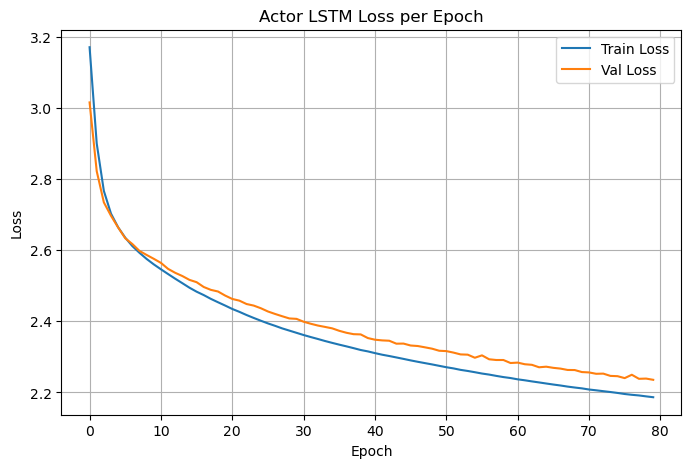

In [308]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Actor LSTM Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

📝 Actor LSTM model was trained on sequences of vector features representing the state of the Tetris game. Train and validation loss decrease steadily, indicating successful learning. However, the test accuracy remains around 32%, which is significantly higher than random guessing but still low. The main limitations are the high complexity of the task (40 classes) and the limited feature set: the vector representation of the board does not capture full information about local configurations. This model will be used as an initial policy for subsequent reinforcement learning training.

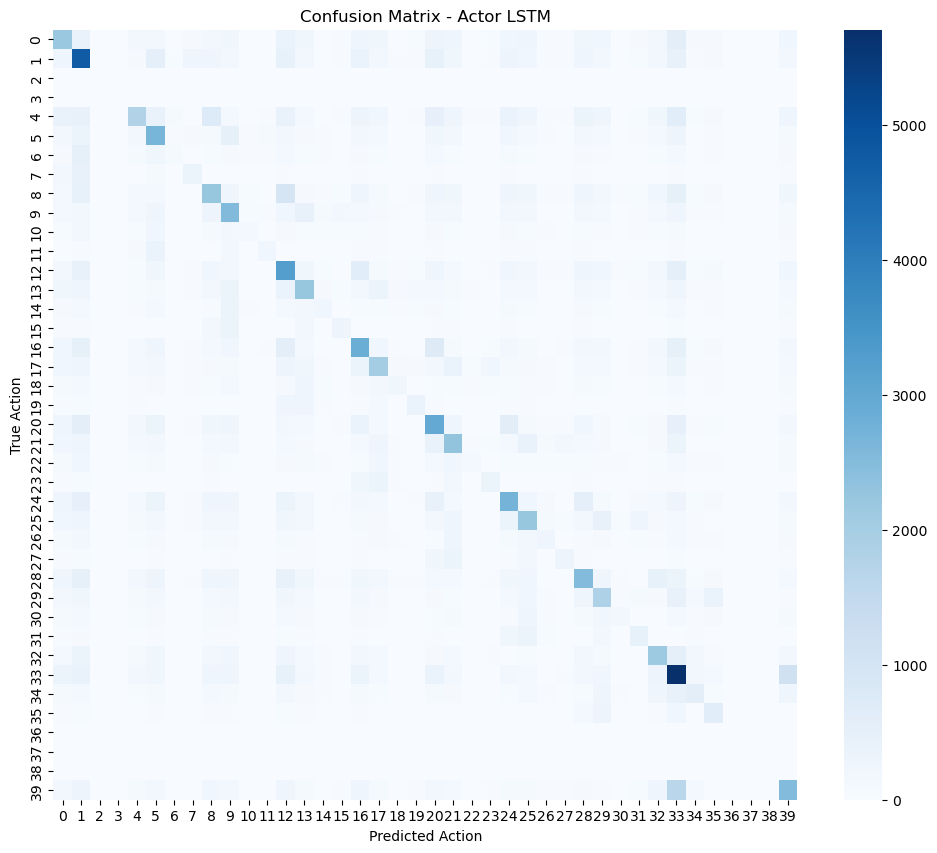

In [310]:
from sklearn.metrics import confusion_matrix

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = torch.argmax(model(X_batch), dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(y_batch.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_actions))

plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap='Blues', annot=False)
plt.xlabel("Predicted Action")
plt.ylabel("True Action")
plt.title("Confusion Matrix - Actor LSTM")
plt.show()


📝 The result of ~32% accuracy for 40 classes using an LSTM on vector features is reasonable and expected. The diagonal of the confusion matrix indicates that the model captures the structure of the player’s actions (imitated actions via a heuristic bot), rather than making random guesses.